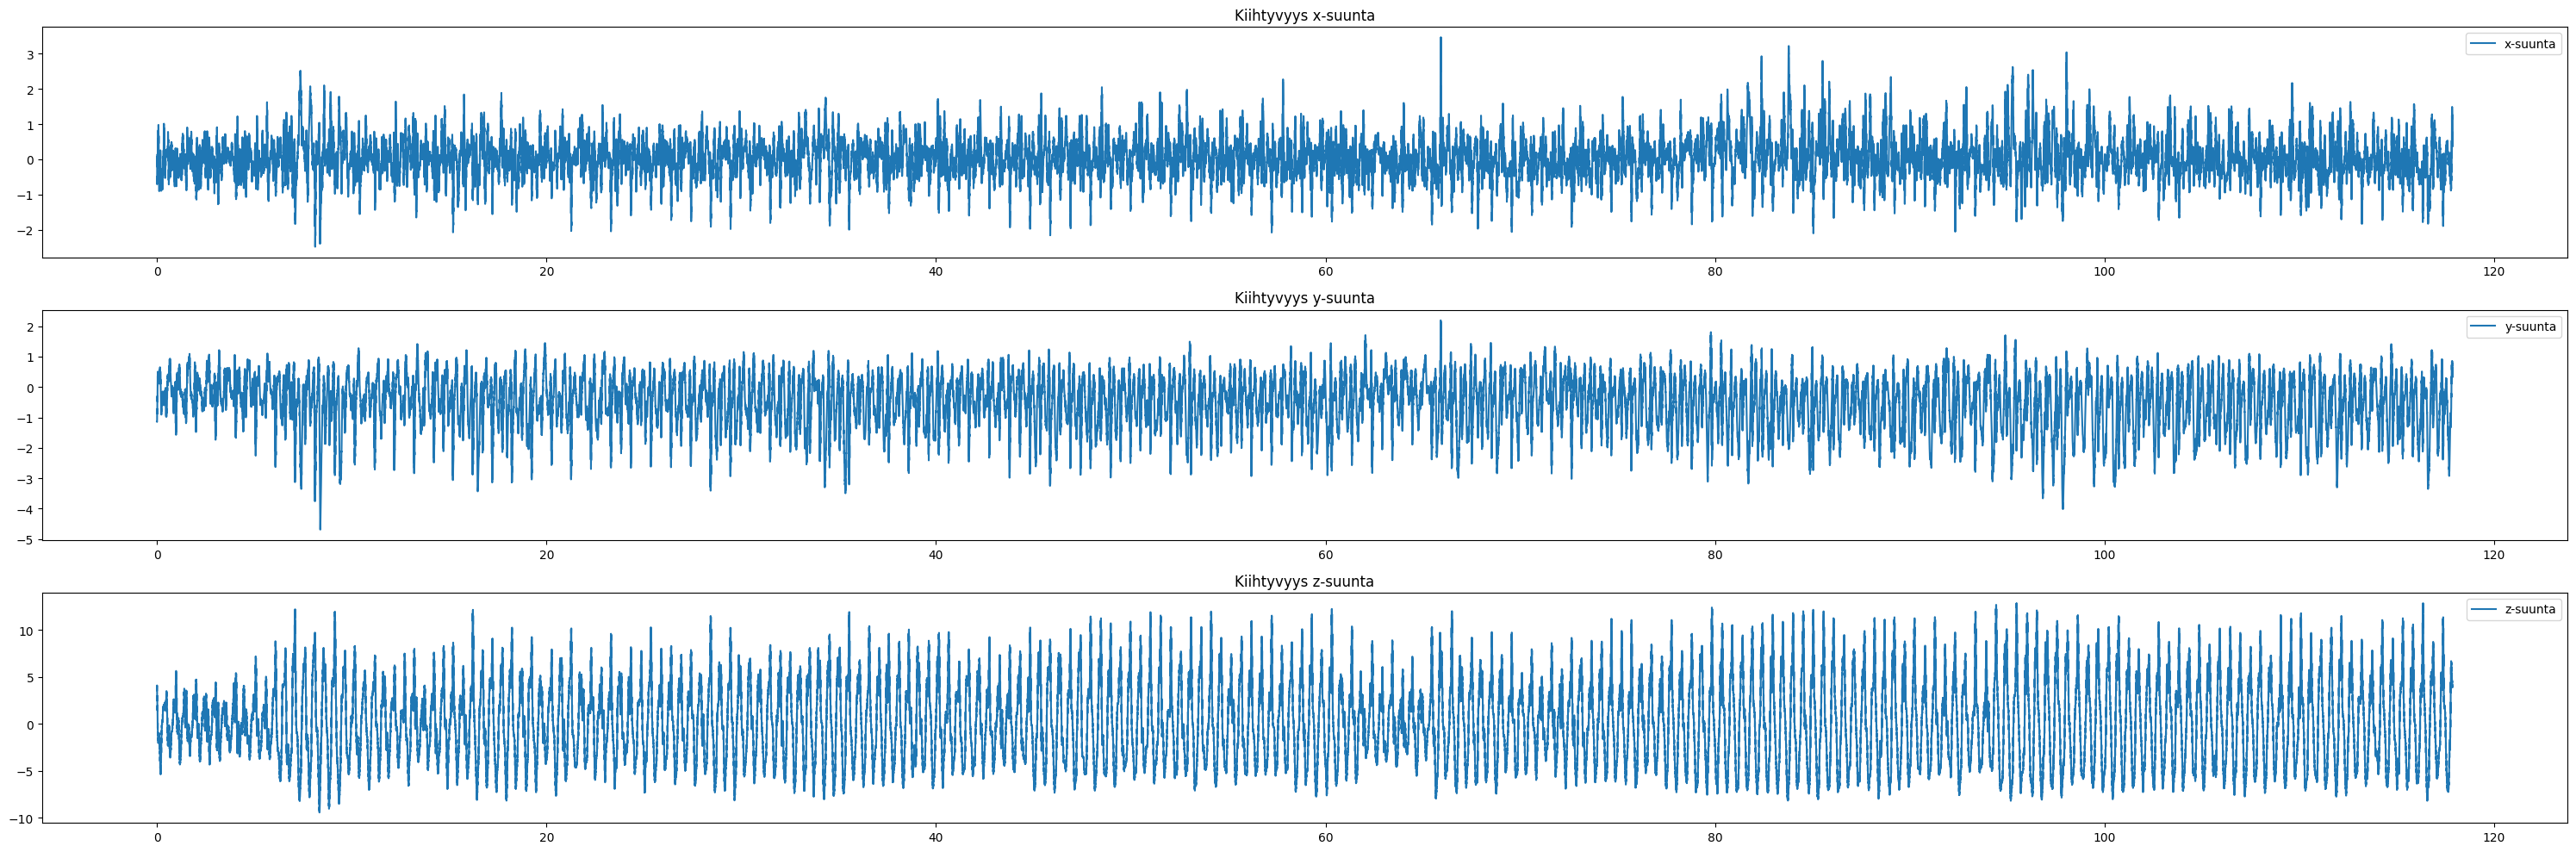

In [13]:
#- Askelmäärä laskettuna suodatetusta kiihtyvyysdatasta
#- Askelmäärä laskettuna kiihtyvyysdatasta Fourier-analyysin perusteella
#- Keskinopeus (GPS-datasta)
#- Kuljettu matka (GPS-datasta)
#- Askelpituus (lasketun askelmäärän ja matkan perusteella)
#Esitä seuraavat kuvaajat
#- Suodatettu kiihtyvyysdata, jota käytit askelmäärän määrittelemiseen. 
#- Analyysiin valitun kiihtyvyysdatan komponentin tehospektritiheys
#- Reittisi kartalla

import pandas as pd
import matplotlib.pyplot as plt

askeldata = pd.read_csv('LAcceleration.csv')

#Poistetaan muutama sekunti alusta koska gps ei ole vielä tarkka
askeldata = askeldata[askeldata['Time (s)'] > 2.144]
#Nollataan indeksi
askeldata = askeldata.reset_index(drop=True)
#Muutetaan aika alkamaan nollasta
askeldata['Time (s)'] = askeldata['Time (s)'] - askeldata['Time (s)'][0]

askeldata.head()

plt.figure(figsize=(30, 10))

plt.subplot(3, 1, 1)
plt.plot(askeldata['Time (s)'], askeldata['Linear Acceleration x (m/s^2)'])
plt.title('Kiihtyvyys x-suunta')
plt.legend(['x-suunta'])

plt.subplot(3, 1, 2)
plt.plot(askeldata['Time (s)'], askeldata['Linear Acceleration y (m/s^2)'])
plt.title('Kiihtyvyys y-suunta')
plt.legend(['y-suunta'])

plt.subplot(3, 1, 3)
plt.plot(askeldata['Time (s)'], askeldata['Linear Acceleration z (m/s^2)'])
plt.title('Kiihtyvyys z-suunta')
plt.legend(['z-suunta'])

plt.tight_layout()
plt.show()

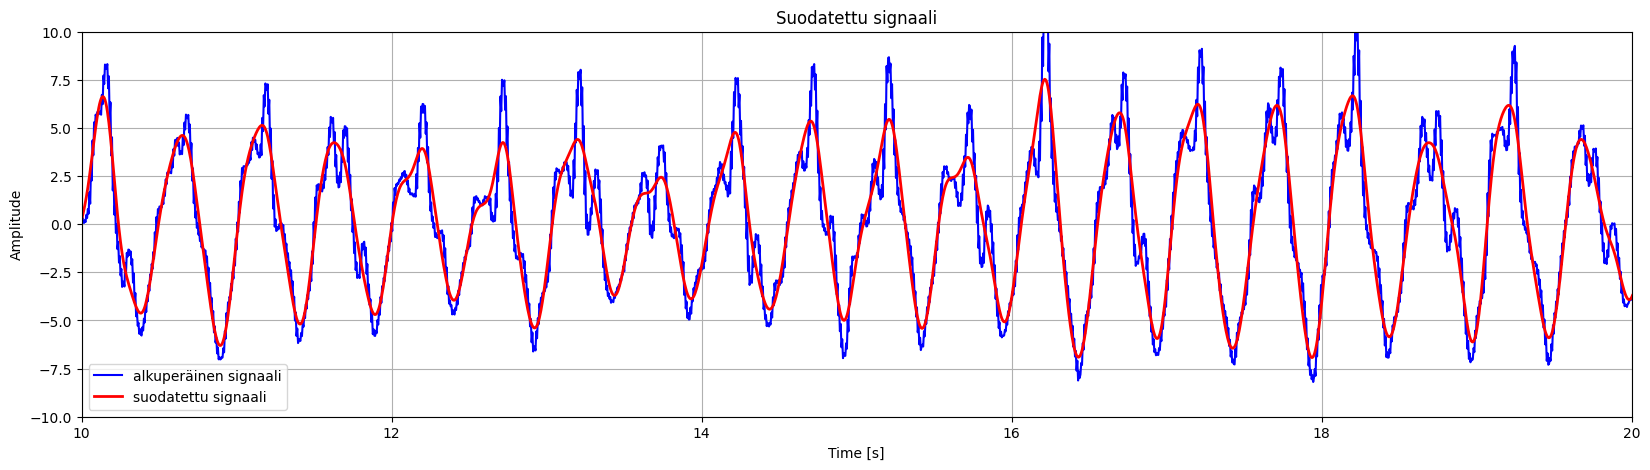

In [14]:
#Z-suunta näyttää eniten jaksolliselta joten otetaan se suodatettavaksi. Aika voimakkailta kiihtyvyyksiltä tuntuvat aikaisempiin mittauksiin verrattuna.
#Johtuu varmaan siitä, että tällä kertaa yritin mahdollisimman vähän vaimentaa puhelimen heilumista kävellessäni.

#Määritä suodatus, jonka avulla voit poistaa valitusta kiihtyvyyden komponentista selvästi askeltaajuutta pienemmät
#ja suuremmat taajuudet.

step_comp=askeldata['Linear Acceleration z (m/s^2)']

from scipy.signal import butter, filtfilt

def butter_lowpass_filter(data, cutoff, nyq, order):
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

#filttereiden parametrit:

#askeldatan aika alkaa nollasta, mutta eipä kosketa ko kerta toimii
T = askeldata['Time (s)'][len(askeldata['Time (s)'])-1] - askeldata['Time (s)'][0] #mittauksen kesto
n = len(askeldata['Time (s)']) #näytteiden määrä
fs = n/T #näytteenottotaajuus
nyq = 0.5 * fs #Nyquist-taajuus
order = 3 #suodattimen aste
cutoff = 1/(0.2) #leikkaustaajuus

filtered_signal = butter_lowpass_filter(step_comp, cutoff, nyq, order)

plt.figure(figsize=(20, 5))
plt.plot(askeldata['Time (s)'], step_comp, 'b-', label='alkuperäinen signaali')
plt.plot(askeldata['Time (s)'], filtered_signal, 'r-', linewidth=2, label='suodatettu signaali')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Suodatettu signaali')
plt.grid()
plt.axis([10, 20, -10, 10])
plt.show()

In [15]:
#Hyvin näyttää pienet tärähdykset suodattuvan signaalista. Lasketaanpa askelten määrä.

#Lasketaan jaksojen määrä signaalissa (ja sitä kautta askelten määrä) laskemalla signaalin nollakohtien ylitysten määrä. 
#Nolla ylitetään kaksi kertaa jokaisen jakson aikana
import numpy as np

jaksot = 0
for i in range(len(filtered_signal)-1):
    if filtered_signal[i]/filtered_signal[i+1] < 0:
        jaksot = jaksot + 1

askelten_maara = np.floor(jaksot/2)
print('Askelmäärä on ', askelten_maara)

Askelmäärä on  229.0


In [16]:
#Askelten määrä oli tarkasti kohdallaan tällä menetelmällä laskettuna. Katsotaanpas vielä maksimien määrällä laskettuna.
maksimit = 0
for i in range(1, len(filtered_signal)-1):
    if filtered_signal[i] > filtered_signal[i-1] and filtered_signal[i] > filtered_signal[i+1]:
        maksimit += 1

print('Askelmäärä on:', maksimit)

Askelmäärä on: 230


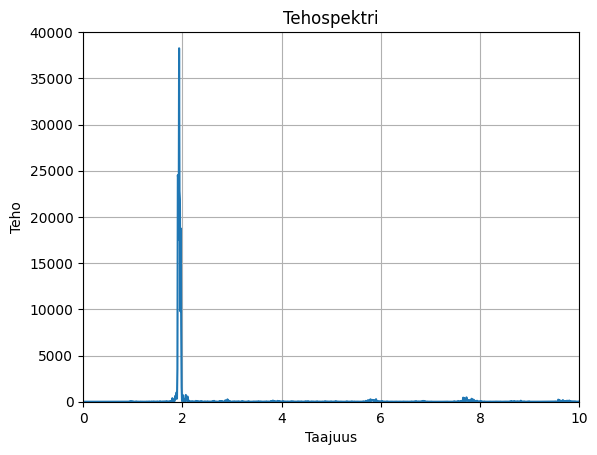

In [17]:
#Tämä menetelmä tuntuu olevan hieman herkempi leikkaustaajuuden muutokselle: cutoff = 1/(0.1) antaa 523 askelta kun taas nollakohdan ylitys pysyy vielä melko järkevissä rajoissa.

#Sitten lasketaan tehospektri sekä askelten taajuus ja määrä fouriermuunnoksen avulla.

f = askeldata['Linear Acceleration z (m/s^2)'] #Valittu signaali
t = askeldata['Time (s)'] #Aika
N = len(askeldata) #Havaintojen määrä
dt = np.max(t)/len(t) #Oletetaan sämpläystaajuus vakioksi

fourier = np.fft.fft(f,N) #Fourier-muunnos
psd = fourier*np.conj(fourier)/N #Tehospektri
freq = np.fft.fftfreq(N,dt) #Taajuudet
L = np.arange(1,int(N/2)) #Rajataan pois nollataajuus ja negatiiviset taajuudet

plt.plot(freq[L],psd[L].real)
plt.title('Tehospektri')
plt.ylabel('Teho')
plt.xlabel('Taajuus')
plt.grid()
plt.axis([0,10,0,40000])
plt.show()

In [18]:
print('Kävelydatan tehokkain taajuus on ',freq[L][psd[L]==np.max(psd[L])][0],'Hz')
print('Tämä vastaa askeleeseen kuluvaa aikaa ',1/freq[L][psd[L]==np.max(psd[L])][0],'s')
print('Tällöin askelmäärä on', freq[L][psd[L]==np.max(psd[L])][0]*np.max(t),' askelta')

Kävelydatan tehokkain taajuus on  1.9343163645230346 Hz
Tämä vastaa askeleeseen kuluvaa aikaa  0.516978514135965 s
Tällöin askelmäärä on 228.0  askelta


In [ ]:
import folium
data = pd.read_csv('Location.csv')
#Poistetaan muutama sekunti alusta koska gps ei ole vielä tarkka
data =data[data['Time (s)'] > 2.144]
#Nollataan indeksi
data = data.reset_index(drop=True)
#Muutetaan aika alkamaan nollasta
data['Time (s)'] = data['Time (s)'] - data['Time (s)'][0]

#määritellään kartan keskipiste ja laajuus (mittakaava, zoomaus)
#keskipiste on loogisesti keskellä reittiä

lat_average = data['Latitude (°)'].mean()
lon_average = data['Longitude (°)'].mean()

#luodaan kartta
my_map = folium.Map(location=[lat_average, lon_average], zoom_start=18)

#piirretään reitti
folium.PolyLine(data[['Latitude (°)', 'Longitude (°)']], color='blue', opacity=1).add_to(my_map)
#merkitään reitin alku ja loppu (https://python-visualization.github.io/folium/latest/getting_started.html#Adding-markers)
#(https://www.w3schools.com/python/pandas/ref_df_iloc.asp)
folium.Marker([data['Latitude (°)'].iloc[0], data['Longitude (°)'].iloc[0]], popup='Alku').add_to(my_map)
folium.Marker([data['Latitude (°)'].iloc[-1], data['Longitude (°)'].iloc[-1]], popup='Loppu').add_to(my_map)

#tallennetaan kartta
my_map.save('gps_reitti.html')
#my_map


In [21]:
#Hieman heiluu reitti pyörätien laidasta laitaan vaikken edes humalassa ollut. Lasketaan kuljettu matka Haversinen kaavaa käyttäen.

#Haversinen kaava: https://en.wikipedia.org/wiki/Haversine_formula

def haversine(lat1, lon1, lat2, lon2):
    R = 6371e3
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    a = np.sin(delta_phi/2) * np.sin(delta_phi/2) + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c

#Valitaan datasta lat ja lon sarakkeet
lat = data['Latitude (°)']
lon = data['Longitude (°)']
data['dist'] = np.zeros(len(data)) #Alustetaan sarake matkalle

#syötetään dataan matka
for i in range(1, len(data)):
    data['dist'].iloc[i] = haversine(lat[i-1], lon[i-1], lat[i], lon[i])

#lasketaan kokonaismatka
total_distance = data['dist'].sum()
print('Kuljettu matka:', total_distance, 'm')

#lasketaan keskinopeus
total_time = data['Time (s)'].iloc[-1] - data['Time (s)'].iloc[0]
average_speed = (total_distance/total_time)
print('Keskinopeus:', average_speed.round(2), 'm/s')

#lasketaan askelpituus
askelpituus = total_distance/askelten_maara
print('Askelten pituus:', askelpituus.round(2), 'm')

#Kuljettu matka: 200.42533936197154 m
#Keskinopeus: 1.71 m/s
#Askelten pituus: 0.88 m



Kuljettu matka: 200.42533936197154 m
Keskinopeus: 1.71 m/s
Askelten pituus: 0.88 m
